## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
# Load X and y splits
x_train_path = os.getenv("X_TRAIN_MERGED_SCALED")
x_test_path  = os.getenv("X_TEST_MERGED_SCALED")
y_train_path = os.getenv("Y_TRAIN_MERGED_SCALED")
y_test_path  = os.getenv("Y_TEST_MERGED_SCALED")

X_train = pd.read_csv(x_train_path)
X_test  = pd.read_csv(x_test_path)
y_train = pd.read_csv(y_train_path)
y_test  = pd.read_csv(y_test_path)

# Optional: quick check
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(875, 23) (875, 1)
(376, 23) (376, 1)


In [3]:
imputer_nonLin = IterativeImputer(
    estimator=BayesianRidge(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_knn = imputer_nonLin.transform(X_train)
X_test_knn = imputer_nonLin.transform(X_test)

In [4]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [5]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [6]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((875, 23), (376, 23))

In [7]:
sel = ['RID', 'Gender', 'Ageatscreening', 'MMSE0m', 'HipsASMbaseline',
       'HipsContrastbaseline', 'HipsCorelationbaseline',
       'HipsSumAveragebaseline', 'HipsSumVariancebaseline',
       'HipsEntropybaseline', 'ERCsASMbaseline', 'ERCsContrastbaseline',
       'ERCsVariancebaseline', 'ERCsSumVariancebaseline',
       'ERCsEntropybaseline', 'ERCsClusterShadebaseline',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline']

In [8]:
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['RID',
 'Gender',
 'Ageatscreening',
 'MMSE0m',
 'HipsASMbaseline',
 'HipsContrastbaseline',
 'HipsCorelationbaseline',
 'HipsSumAveragebaseline',
 'HipsSumVariancebaseline',
 'HipsEntropybaseline',
 'ERCsASMbaseline',
 'ERCsContrastbaseline',
 'ERCsVariancebaseline',
 'ERCsSumVariancebaseline',
 'ERCsEntropybaseline',
 'ERCsClusterShadebaseline',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'HipposcampusVolumebaseline']

In [9]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((875, 19), (376, 19))

## TPE

In [ ]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
    )
    
    C = trial.suggest_float('C', 1e-3, 100, log=True)
    tol = trial.suggest_float('tol', 1e-6, 1e-2, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    model = LogisticRegression(C=C,
                       tol=tol,
                       class_weight="balanced",
                       solver=solver,
                       max_iter=max_iter,
                       penalty='l2',
                       n_jobs=-1,
                       random_state=42)

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [11]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [12]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-11-16 12:01:54,009] A new study created in memory with name: no-name-c7c65049-6453-4987-9e4d-a1879ab90901
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-

In [13]:
study.best_params

{'C': 23.54195082203017,
 'tol': 0.00039243232284196785,
 'solver': 'newton-cg',
 'max_iter': 921}

In [14]:
study.best_value

0.7257172202214218

In [15]:
r = study.trials_dataframe()

r.head()

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_solver,params_tol,state
0,0,0.506692,2025-11-16 12:01:54.015932,2025-11-16 12:02:00.365481,0 days 00:00:06.349549,2.403930,922,sag,0.000003,COMPLETE
1,1,0.709229,2025-11-16 12:02:00.365481,2025-11-16 12:02:02.662327,0 days 00:00:02.296846,0.005456,200,newton-cg,0.001304,COMPLETE
2,2,0.725717,2025-11-16 12:02:02.662327,2025-11-16 12:02:07.162382,0 days 00:00:04.500055,23.541951,921,newton-cg,0.000392,COMPLETE
3,3,0.714765,2025-11-16 12:02:07.162382,2025-11-16 12:02:10.279586,0 days 00:00:03.117204,0.002650,585,newton-cg,0.000017,COMPLETE
4,4,0.506692,2025-11-16 12:02:10.281614,2025-11-16 12:02:11.029354,0 days 00:00:00.747740,0.707821,136,saga,0.009689,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_15308\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


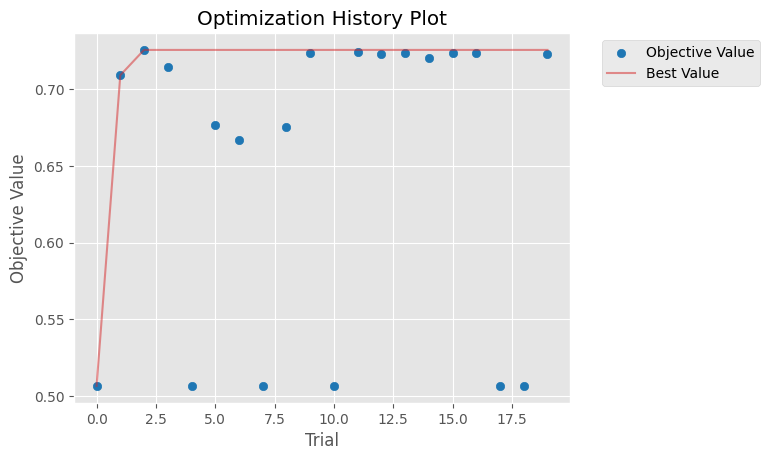

In [16]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_15308\924295173.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='C', ylabel='Objective Value'>,
       <Axes: xlabel='max_iter'>, <Axes: xlabel='solver'>,
       <Axes: xlabel='tol'>], dtype=object)

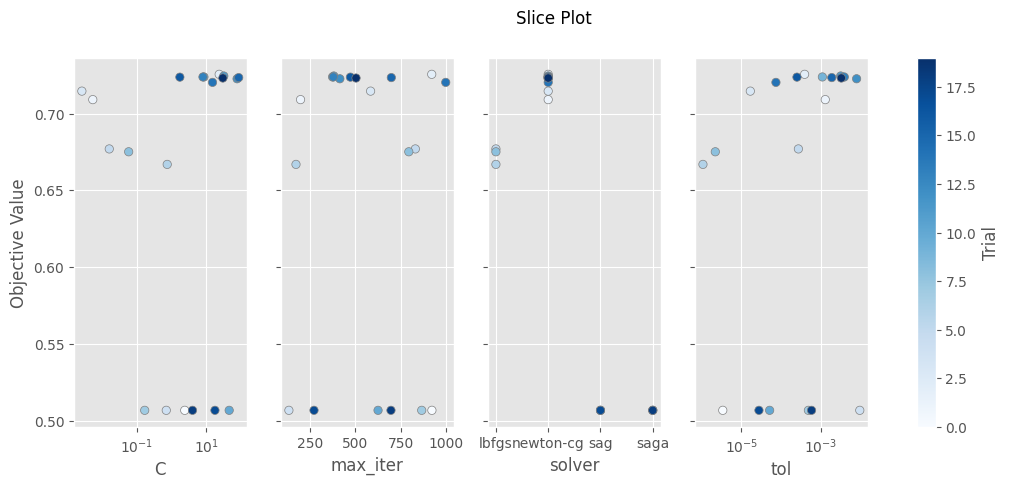

In [17]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["C", "solver", "tol", "max_iter"],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_15308\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

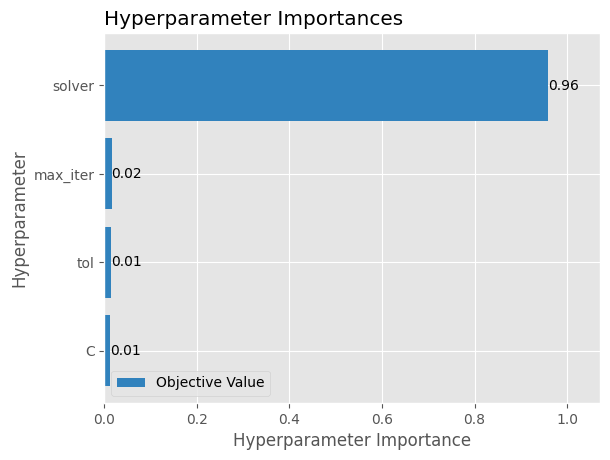

In [18]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_15308\1937692550.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

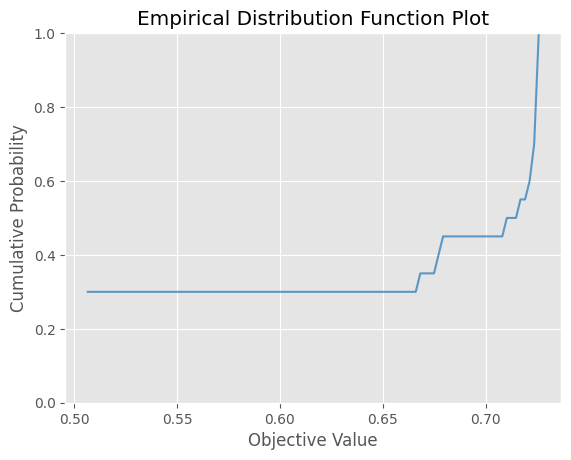

In [19]:
optuna.visualization.matplotlib.plot_edf([study])


### Classification

In [20]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)
        
        model = LogisticRegression(C=study.best_params['C'],
                       tol=study.best_params['tol'],
                       class_weight="balanced",
                       penalty='l2',
                       solver=study.best_params['solver'],
                       max_iter=study.best_params['max_iter'],
                       random_state=42)

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [21]:
trained_lg_n, metrics_lg_n = run_model("Logistic Regression", "Complete", X_train_knn_t, y_train)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", "Boruta", X_train_t, y_train)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\utils\optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\utils\optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search

In [22]:
validation_df = pd.concat([metrics_lg_n, metrics_lg_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier          Metric            Feature Selection Fit Time Total Features               
Logistic Regression balanced_accuracy Complete          0.654    23                   0.751   
                                      Boruta            0.542    19                   0.749   

                                                                                 Std Train  \
Classifier          Metric            Feature Selection Fit Time Total Features              
Logistic Regression balanced_accuracy Complete          0.654    23                  0.007   
                                      Boruta            0.542    19                  0.007   

                                                                                 Mean Test  \
Classifier          Metric            Feature Selection Fit Time Total Features              
Logistic Regression balanced_accuracy Complete          0.654    23                  0.714   
                                      Boruta            0.542    19                  0.726   

                                                                                 Std Test  
Classifier          Metric            Feature Selection Fit Time Total Features            
Logistic Regression balanced_accuracy Complete          0.654    23                 0.049  
                                      Boruta            0.542    19                 0.049

In [23]:
from sklearn.utils import resample

def bootstrap_ci(model, X, y, metric_fn, n_iterations, ci=0.95, use_proba=False):
    scores = []
    n = len(X)
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X, y, n_samples=n, stratify=y)
        try:
            y_pred = model.predict_proba(X_resampled) if use_proba else model.predict(X_resampled)
            score = metric_fn(y_resampled, y_pred)
            if not np.isnan(score):
                scores.append(score)
        except Exception:
            # Skip this bootstrap sample if error occurs (e.g. missing class for roc_auc)
            continue
    if len(scores) == 0:
        return (np.nan, np.nan)
    lower = np.percentile(scores, (1 - ci) / 2 * 100)
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    std_dev = np.std(scores)
    return round(lower, 3), round(upper, 3), round(std_dev, 3)

In [24]:
from sklearn.metrics import confusion_matrix

def compute_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = total - (tp + fp + fn)
    specificity = tn / (tn + fp)
    return round(np.nanmean(specificity), 3)

In [25]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": accuracy_score(y_train, pred_train),
                "balanced_accuracy": balanced_accuracy_score(y_train, pred_train),
                "precision_macro": precision_score(y_train, pred_train, average="macro", zero_division=0),
                "recall_macro": recall_score(y_train, pred_train, average="macro", zero_division=0),
                "f1_macro": f1_score(y_train, pred_train, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_train, pred_train_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_train, pred_train),
        }

        metrics_test = {
                "accuracy": accuracy_score(y_test, pred_test),
                "balanced_accuracy": balanced_accuracy_score(y_test, pred_test),
                "precision_macro": precision_score(y_test, pred_test, average="macro", zero_division=0),
                "recall_macro": recall_score(y_test, pred_test, average="macro", zero_division=0),
                "f1_macro": f1_score(y_test, pred_test, average="macro", zero_division=0),
                "roc_auc_macro": roc_auc_score(y_test, pred_test_proba, average="macro", multi_class="ovr"),
                "specificity_macro": compute_specificity(y_test, pred_test),
        }
                
        elapsed_time = time.time() - start_time
        
        # Metric functions for bootstrap CI (exclude ROC AUC here)
        metric_fns = {
                "accuracy": accuracy_score,
                "balanced_accuracy": balanced_accuracy_score,
                "precision_macro": lambda yt, yp: precision_score(yt, yp, average="macro", zero_division=0),
                "recall_macro": lambda yt, yp: recall_score(yt, yp, average="macro", zero_division=0),
                "f1_macro": lambda yt, yp: f1_score(yt, yp, average="macro", zero_division=0),
                "roc_auc_macro": lambda yt, yp: roc_auc_score(yt, yp, average="macro", multi_class="ovr"),
                "specificity_macro": lambda yt, yp: compute_specificity(yt, yp),
        }

        # Bootstrap confidence intervals
        ci_test = {
                m: bootstrap_ci(
                model, X_test, y_test, fn,
                n_iterations=1000,
                use_proba=(m == "roc_auc_macro")
                )
                for m, fn in metric_fns.items()
        }

        # Separate CI bounds and std with clear variable names
        ci_bounds = []
        std_values = []
                
        for lower, upper, std in ci_test.values():
                ci_bounds.append(f"[{round(lower, 3)}, {round(upper, 3)}]")
                std_values.append(round(std, 3)) 
                
        # Round metric values
        train_rounded = [round(score, 3) for score in metrics_train.values()]
        test_rounded = [round(score, 3) for score in metrics_test.values()] 
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "None",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": list(metrics_train.keys()),      
                "Train data": train_rounded,
                "Test data": test_rounded,
                "95% CI": ci_bounds,
                "Std Dev": std_values,
        })
        
        return pred_metrics_df

In [26]:
results = "all"
prediction_df_report = None

if results == "all":

    pred_ngb_n = eval_model("Logitic Regression", trained_lg_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_ngb_t = eval_model("Logitic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_n, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_ngb_t = eval_model("NGBoost", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier         Classification Time Total Features Metric                          
None              Logitic Regression 0.070               23             accuracy                0.768   
                                                                        balanced_accuracy       0.751   
                                                                        precision_macro         0.728   
                                                                        recall_macro            0.751   
                                                                        f1_macro                0.735   
                                                                        roc_auc_macro           0.904   
                                                                        specificity_macro       0.882   
                                     0.048               19             accuracy                0.770   
                                                                        balanced_accuracy       0.750   
                                                                        precision_macro         0.728   
                                                                        recall_macro            0.750   
                                                                        f1_macro                0.735   
                                                                        roc_auc_macro           0.903   
                                                                        specificity_macro       0.883   

                                                                                           Test data  \
Feature Selection Classifier         Classification Time Total Features Metric                         
None              Logitic Regression 0.070               23             accuracy               0.745   
                                                                        balanced_accuracy      0.704   
                                                                        precision_macro        0.696   
                                                                        recall_macro           0.704   
                                                                        f1_macro               0.697   
                                                                        roc_auc_macro          0.891   
                                                                        specificity_macro      0.864   
                                     0.048               19             accuracy               0.758   
                                                                        balanced_accuracy      0.725   
                                                                        precision_macro        0.718   
                                                                        recall_macro           0.725   
                                                                        f1_macro               0.718   
                                                                        roc_auc_macro          0.892   
                                                                        specificity_macro      0.871   

                                                                                                   95% CI  \
Feature Selection Classifier         Classification Time Total Features Metric                              
None              Logitic Regression 0.070               23             accuracy           [0.699, 0.785]   
                                                                        balanced_accuracy  [0.649, 0.755]   
                                                                        precision_macro    [0.649, 0.748]   
                                                                        recall_macro       [0.652, 0.753]   
                                                                        f1_macro           

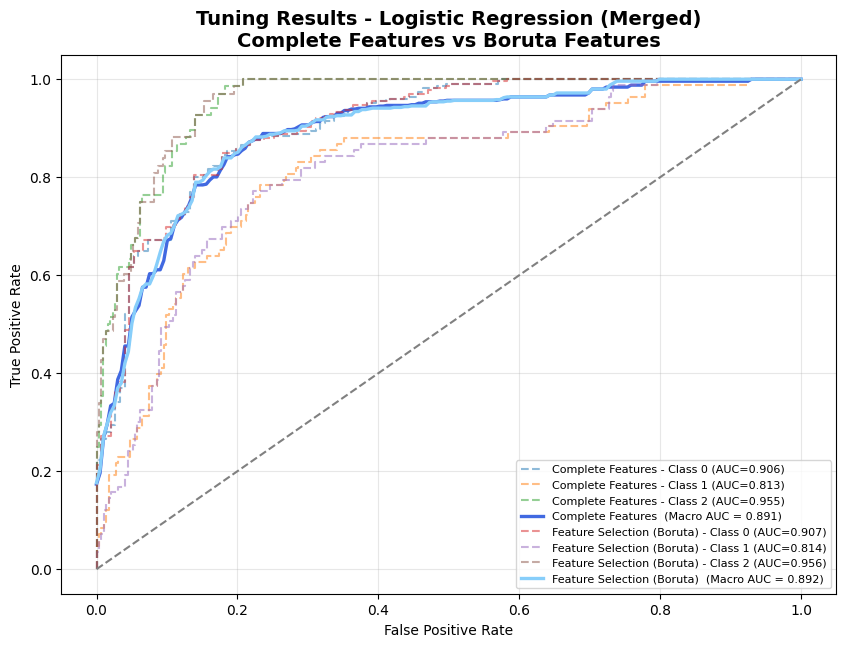

In [27]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_lr(trained_lg_n, trained_lg_t, X_test_full, X_test_fs, y_test, show_per_class=True):

    classes = sorted(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=classes)
    plt.style.use('default')
    
    plt.figure(figsize=(10, 7))

    models_data = {
        "Complete Features": (trained_lg_n, X_test_full),
        "Feature Selection (Boruta)": (trained_lg_t, X_test_fs)
    }

    for label, (model, Xtest) in models_data.items():

        # Predict probabilities
        y_proba = model.predict_proba(Xtest)

        fpr = {}
        tpr = {}
        auc_scores = []

        for i in range(len(classes)):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
            auc_i = auc(fpr[i], tpr[i])
            auc_scores.append(auc_i)

            if show_per_class:
                plt.plot(
                    fpr[i], tpr[i],
                    linestyle='--',
                    alpha=0.5,
                    label=f"{label} - Class {classes[i]} (AUC={auc_i:.3f})"
                )

        # Macro AUC
        auc_macro = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")

        # Macro ROC Curve (smoothed)
        fpr_macro = np.linspace(0, 1, 200)
        tpr_macro = np.mean([np.interp(fpr_macro, fpr[i], tpr[i]) for i in range(len(classes))], axis=0)

        # Macro curve
        plt.plot(
            fpr_macro, tpr_macro,
            linewidth=2.4,
            color='royalblue' if "Complete" in label else "lightskyblue",
            label=f"{label}  (Macro AUC = {auc_macro:.3f})"
        )

    # Random baseline
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

    plt.title("Tuning Results - Logistic Regression (Merged)\nComplete Features vs Boruta Features", fontsize=14, fontweight='bold')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(alpha=0.3)
    plt.show()

# Test the function
plot_roc_lr(
    trained_lg_n, trained_lg_t,
    X_test_knn_t, X_test_t,
    y_test,
    show_per_class=True
)


### Export model

In [28]:
trained_lg_n

LogisticRegression(C=23.54195082203017, class_weight='balanced', max_iter=921,
                   random_state=42, solver='newton-cg',
                   tol=0.00039243232284196785)

In [35]:
print("Logistic Regression number of features:", trained_lg_t.coef_.shape[1])

Logistic Regression number of features: 19


In [36]:
import pickle

# Save the trained model using pickle
with open("logit_model.pkl", "wb") as file:
    pickle.dump(trained_lg_t, file)

print("Logistic model saved successfully!")

Logistic model saved successfully!


In [38]:
# Load the saved model using pickle
with open("logit_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)